/home/spellsharp/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
<ipython-input-1-c4dd5b86027d>:8: RuntimeWarning: overflow encountered in exp
  return K / (1 + np.exp(-r * (t - t0)))
/home/spellsharp/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Saved: logistic_fit_results.csv


<ipython-input-1-c4dd5b86027d>:8: RuntimeWarning: overflow encountered in exp
  return K / (1 + np.exp(-r * (t - t0)))
/home/spellsharp/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
<ipython-input-1-c4dd5b86027d>:8: RuntimeWarning: overflow encountered in exp
  return K / (1 + np.exp(-r * (t - t0)))
/home/spellsharp/anaconda3/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


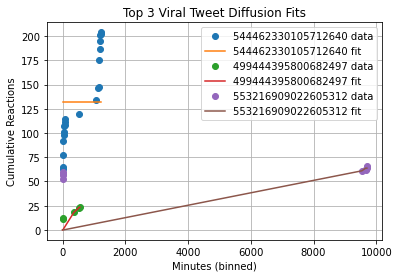

In [1]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

def logistic(t, K, r, t0):
    """Logistic growth model."""
    return K / (1 + np.exp(-r * (t - t0)))

def fit_tweet_logistic(x, y):
    """Fit logistic curve to a tweet's timeline."""
    try:
        popt, _ = curve_fit(logistic, x, y, p0=[max(y), 0.1, np.median(x)], maxfev=10000)
        return popt  # K, r, t0
    except:
        return None

def build_cumulative_timelines(df):
    binned_counts = (
        df.groupby(["sourceTweetID", "time_bin"])
        .size()
        .reset_index(name="bin_count")
    )
    binned_counts["cumulative_count"] = (
        binned_counts
        .sort_values(["sourceTweetID", "time_bin"])
        .groupby("sourceTweetID")["bin_count"]
        .cumsum()
    )
    return binned_counts

def main():
    df = pd.read_csv("outputs/diffusion_timelines_v2.csv")
    df = df[df["minutes_since_source"] >= 0]
    timelines = build_cumulative_timelines(df)

    fitted = []
    for source_id in df["sourceTweetID"].unique():
        data = timelines[timelines["sourceTweetID"] == source_id]
        x = data["time_bin"].values
        y = data["cumulative_count"].values

        if len(x) < 4:
            continue  # skip tweets with too few points

        result = fit_tweet_logistic(x, y)
        if result is not None:
            K, r, t0 = result
            fitted.append({
                "sourceTweetID": source_id,
                "K": K,
                "r": r,
                "t0": t0,
                "final_reactions": y[-1],
                "data_points": len(x)
            })

    results_df = pd.DataFrame(fitted)
    results_df.to_csv("logistic_fit_results_v2.csv", index=False)
    print("Saved: logistic_fit_results.csv")

    # Optional: plot top 3 most viral
    top = results_df.sort_values("r", ascending=False).head(3)
    for tid in top["sourceTweetID"]:
        data = timelines[timelines["sourceTweetID"] == tid]
        x = data["time_bin"].values
        y = data["cumulative_count"].values
        fit = fit_tweet_logistic(x, y)
        if fit is not None:
            y_pred = logistic(x, *fit)
            plt.plot(x, y, "o", label=f"{tid} data")
            plt.plot(x, y_pred, "-", label=f"{tid} fit")
    
    plt.title("Top 3 Viral Tweet Diffusion Fits")
    plt.xlabel("Minutes (binned)")
    plt.ylabel("Cumulative Reactions")
    plt.legend()
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()
